In [2]:
# Load and Inspect Step
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data we just downloaded
# We specify data types to save memory
df = pd.read_csv('../data/processed/movies_merged.csv')

# 1. Quick Health Check
print(f"Total Movies: {len(df)}")
print("\nFirst 3 rows:")
display(df.head(3))

# 2. Check Data Types
print("\nData Types:")
print(df.dtypes)

Total Movies: 251679

First 3 rows:


,tconst,titleType,primaryTitle,startYear,genres,averageRating,numVotes
0,tt0015724,movie,Dama de noche,1993,"Drama,Mystery,Romance",6.2,34
1,tt0035423,movie,Kate & Leopold,2001,"Comedy,Fantasy,Romance",6.4,93257
2,tt0036606,movie,"Another Time, Another Place",1983,"Drama,War",6.4,379



Data Types:
tconst            object
titleType         object
primaryTitle      object
startYear          int64
genres            object
averageRating    float64
numVotes           int64
dtype: object


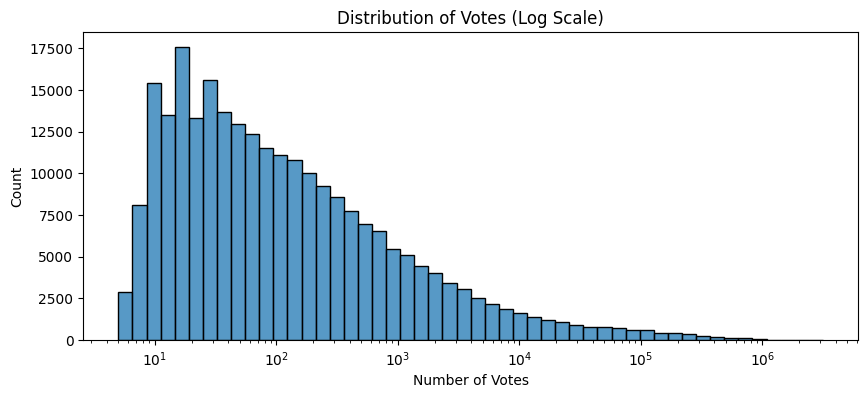

Movies before filter: 251679
Movies after filter (> 100 votes): 112682
Data reduction: 55.2% removed


In [3]:
# Filter Step
# PROBABILITY LESSON: The "Long Tail"
# Most movies have almost 0 votes. We only want the "head" of the distribution.

# Let's see the distribution of votes first
plt.figure(figsize=(10, 4))
sns.histplot(df['numVotes'], bins=50, log_scale=True)
plt.title("Distribution of Votes (Log Scale)")
plt.xlabel("Number of Votes")
plt.show()

# THE CUTOFF
MIN_VOTES = 100
df_filtered = df[df['numVotes'] >= MIN_VOTES].copy()

print(f"Movies before filter: {len(df)}")
print(f"Movies after filter (> {MIN_VOTES} votes): {len(df_filtered)}")
print(f"Data reduction: {100 - (len(df_filtered)/len(df)*100):.1f}% removed")

In [4]:
# Explode Step
# 1. Convert string "Action,Comedy" into list ["Action", "Comedy"]
df_filtered['genres'] = df_filtered['genres'].str.split(',')

# 2. Explode: Turn lists into rows
# If a movie has 3 genres, it becomes 3 rows.
df_exploded = df_filtered.explode('genres')

print("Row count increased because we duplicated movies for each genre:")
print(f"New shape: {df_exploded.shape}")

# 3. Check unique genres to ensure no garbage data
print("\nUnique Genres found:")
print(df_exploded['genres'].unique())

Row count increased because we duplicated movies for each genre:
New shape: (224703, 7)

Unique Genres found:
['Comedy' 'Fantasy' 'Romance' 'Drama' 'War' 'Documentary' 'Action'
 'Adventure' 'Thriller' 'History' 'Horror' 'Crime' 'Sci-Fi' 'Mystery'
 'Biography' 'Animation' 'Family' 'Sport' 'Western' 'Music' 'Adult'
 'Musical' 'Reality-TV' 'News' 'Talk-Show' 'Game-Show']


C:\Users\ahmed\AppData\Local\Temp\ipykernel_32932\1504103993.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


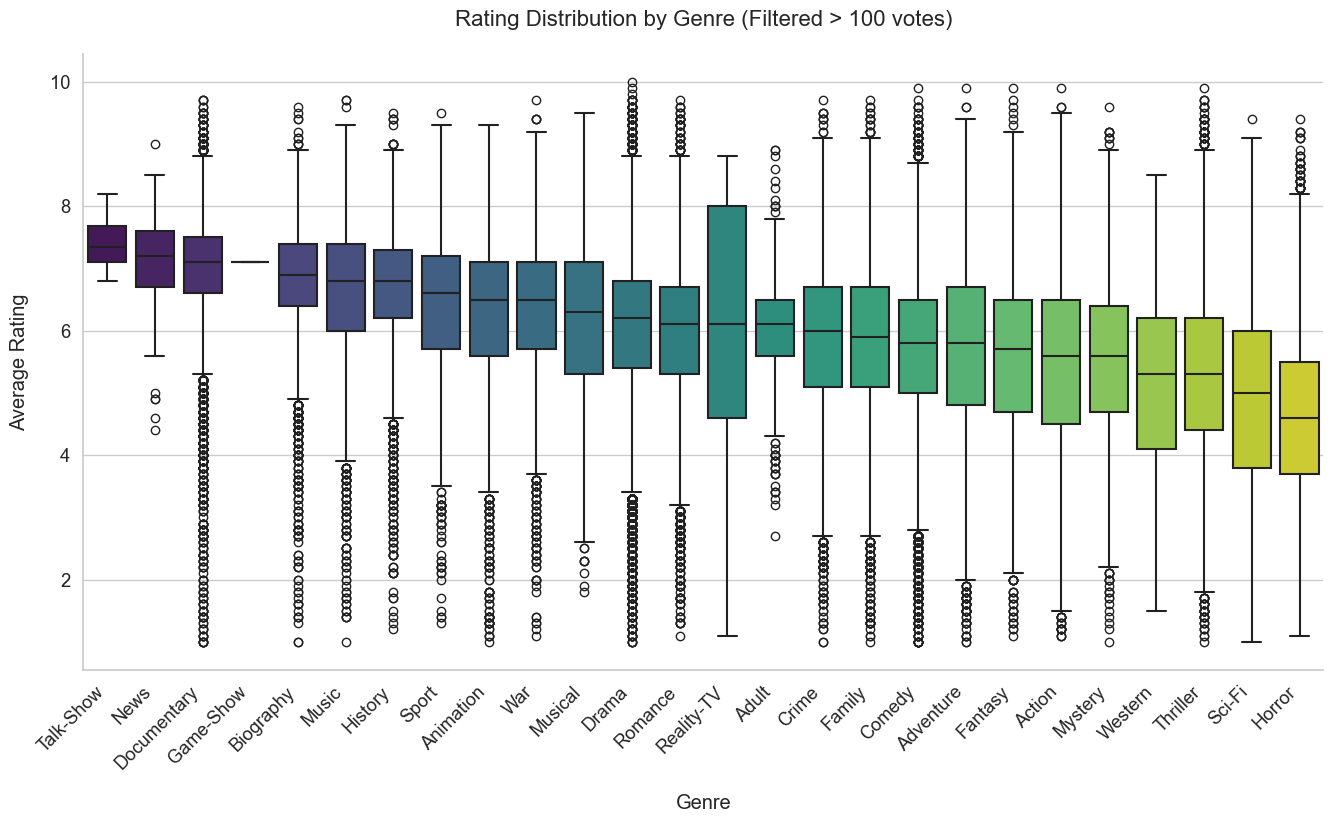

In [7]:
# Boxplots The Truth Step
# Set the theme and adjust font scale slightly up for a bigger plot
sns.set_theme(style="whitegrid", font_scale=1.2)

# INITIALIZE CANVAS: Make it bigger (Width=16, Height=8)
plt.figure(figsize=(16, 8))

# Calculate order (keep this the same)
order = df_exploded.groupby('genres')['averageRating'].median().sort_values(ascending=False).index

# Create Plot
sns.boxplot(
    data=df_exploded, 
    x='genres', 
    y='averageRating', 
    order=order,
    palette='viridis',
    linewidth=1.5 # Make lines a bit thicker
)

# Formatting
plt.xticks(rotation=45, ha='right') # Rotate and align right for readability
plt.title("Rating Distribution by Genre (Filtered > 100 votes)", fontsize=16, pad=20)
plt.xlabel("Genre", labelpad=15)
plt.ylabel("Average Rating", labelpad=15)

# Remove the top and right spines for a cleaner look
sns.despine()

plt.show()

In [8]:
# --- STEP 1: CALCULATE WEIGHTED RATING PER MOVIE ---

# C = The mean rating across the WHOLE report (the baseline)
C = df_filtered['averageRating'].mean()

# m = The minimum votes required (we already filtered for 100, so we use that)
m = 100

def weighted_rating(x, m=m, C=C):
    v = x['numVotes']
    R = x['averageRating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(v+m) * C)

# Apply this math to every single row
# We use .loc to ensure we are modifying the dataframe safely
df_exploded['weighted_score'] = df_exploded.apply(weighted_rating, axis=1)

print(f"Global Average (C): {C:.2f}")
print("Weighted scores calculated.")
display(df_exploded[['primaryTitle', 'averageRating', 'numVotes', 'weighted_score']].head())

Global Average (C): 5.84
Weighted scores calculated.


,primaryTitle,averageRating,numVotes,weighted_score
1,Kate & Leopold,6.4,93257,6.399400
1,Kate & Leopold,6.4,93257,6.399400
1,Kate & Leopold,6.4,93257,6.399400
2,"Another Time, Another Place",6.4,379,6.283131
2,"Another Time, Another Place",6.4,379,6.283131


In [9]:
# --- STEP 2: GROUP BY GENRE & CALCULATE METRICS ---

# We define a custom dictionary of aggregations
aggregations = {
    'primaryTitle': 'count',       # How many movies?
    'numVotes': 'mean',            # Average popularity
    'weighted_score': 'mean',      # The "True" Quality of the genre
    'averageRating': [
        'mean', 
        'std', 
        lambda x: x.quantile(0.99) # The p99 (Top 1%)
    ]
}

# Group by genre
genre_stats = df_exploded.groupby('genres').agg(aggregations)

# Rename columns to make them readable
genre_stats.columns = [
    'movie_count', 
    'avg_votes', 
    'avg_weighted_score', 
    'raw_avg_rating', 
    'std_dev', 
    'p99_ceiling'
]

# Sort by the "Elite" potential (p99) to see which genres produce the best masterpieces
genre_stats = genre_stats.sort_values(by='p99_ceiling', ascending=False)

# Make it look nice
display(genre_stats.style.background_gradient(cmap='Greens', subset=['avg_weighted_score', 'p99_ceiling']))

,movie_count,avg_votes,avg_weighted_score,raw_avg_rating,std_dev,p99_ceiling
genres,,,,,,
Documentary,12032,1301.039561,6.721737,7.011910,0.930040,8.800000
Music,3021,7864.265475,6.484861,6.624727,1.200930,8.800000
Musical,1325,6462.148679,6.121727,6.152981,1.351345,8.776000
Reality-TV,20,300.800000,5.780165,5.855000,2.531169,8.762000
History,3586,8824.386224,6.520901,6.647909,1.051328,8.600000
Sport,1917,9990.753260,6.315032,6.404278,1.196534,8.600000
Biography,4667,16401.817013,6.652265,6.789136,0.961672,8.534000
Family,5125,9665.329756,5.833133,5.804293,1.301286,8.500000
War,1789,11884.403577,6.244971,6.292174,1.274788,8.500000


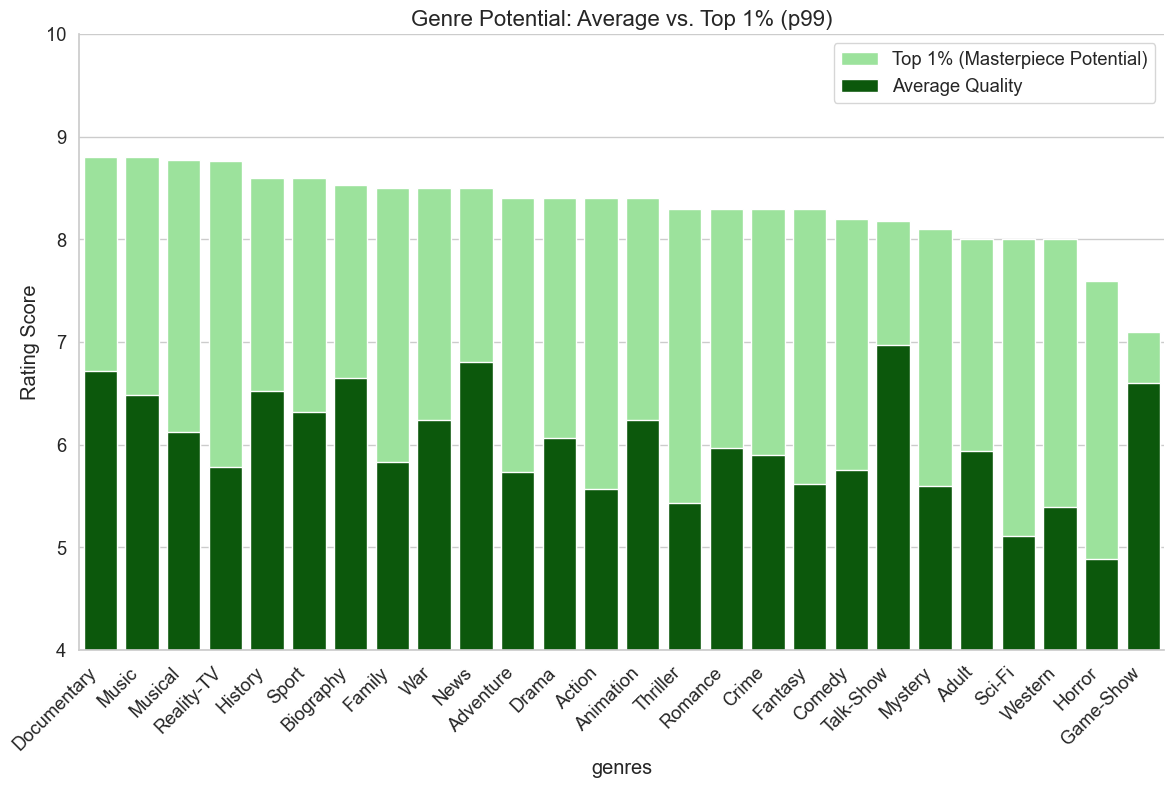

In [ ]:
# --- STEP 3: VISUALIZE AVERAGE VS ELITE POTENTIAL ---

plt.figure(figsize=(14, 8))

# We reset index to use 'genres' as a column for plotting
plot_data = genre_stats.reset_index()

# 1. Plot the "Ceiling" (p99) as a light bar
sns.barplot(x='genres', y='p99_ceiling', data=plot_data, color='lightgreen', label='Top 1% (Masterpiece Potential)')

# 2. Plot the "Average" as a dark bar on top
sns.barplot(x='genres', y='avg_weighted_score', data=plot_data, color='darkgreen', label='Average Quality')

plt.xticks(rotation=45, ha='right')
plt.ylim(4, 10) # Zoom in on the relevant range
plt.title("Genre Potential: Average vs. Top 1% (p99)", fontsize=16)
plt.ylabel("Rating Score")
plt.legend(loc='upper right')
sns.despine()

plt.show()